In [1]:
from copy import deepcopy
import datetime
import matplotlib
from matplotlib.patches import Ellipse
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle as pkl
import seaborn as sns
import scipy.interpolate as intrp
import scipy.signal as sig
import scipy.stats as st
from skimage.filters import threshold_otsu

import Objectives.Electrophysiology.ephys_objs as epo
import Objectives.Electrophysiology.ephys_util as epu

import Utility.ABF_util as abf
import Utility.DataIO_util as DIO
import Utility.runfile_util as rfu
import Utility.utility as utl

In [2]:
plt.close('all')

sns.set({'legend.frameon':True}, color_codes=True)
matplotlib.rc("font", size=20)
matplotlib.rc("xtick", labelsize=16)
matplotlib.rc("ytick", labelsize=16)
matplotlib.rc("axes", labelsize=20)
matplotlib.rc("axes", titlesize=24)
matplotlib.rc("legend", fontsize=18)
matplotlib.rc("figure", titlesize=24)

In [3]:
figDir = "./Figures/FlourakisDataReview/"

infoDir = "./Runfiles/RedCheck_Overview/"

infoDict = rfu.getInfo(infoDir, verbose=1)

dataDir = DIO.get_data_dir(dataDir="")

Loading info from ./Runfiles/RedCheck_Overview/


In [4]:
################################################################################
## Text Processing Functions for Loading CSV
################################################################################
def strip(text):
    try:
        return text.strip()
    except AttributeError:
        return text

def make_float(text):
    try:
        return float(strip(text))
    except TypeError:
        return strip(text)
    except ValueError:
        text = strip(text)
        if len(text) == 0:
            return np.NaN
        else:
            return text
        
def make_int(text):
    try:
        return int(strip(text))
    except TypeError:
        return strip(text)
    except ValueError:
        text = strip(text)
        if len(text) == 0:
            return np.NaN
        else:
            return text

def check_list(text):
    text = strip(text)
    if text.lower() == 'all':
        return [0, -1]
    elif text.lower() == 'none':
        return []
    else:
        return make_list(text)

def make_list(text):
    strip(text)
    text = text[1:-1].split(",")
    text = [int(t.strip()) for t in text]
    return text

def convert_time(text):
    text = strip(text)
    if len(text) == 0:
        return np.NaN

    times = text.split(":")
    if len(times) == 0:
        return np.NaN
    else:
        hours = float(times[0])
        if len(times) == 1:
            return float(hours)
        elif len(times) == 2:
            minutes = float(times[1])/60.
            return hours + minutes
        else:
            return np.NaN

def isWT(entry):
    if entry['Geno'] == 'WT':
        return True
    else:
        return False

In [5]:
csvFile = "./Misc/RedChecksData_Flourakis_AllRecordings_Annotated_Oct14_2019.csv"

converters = {
    "Date":strip,
    "DateStr":strip,
    "DateNo":make_int,
    "RecTime":make_float,
    "ZT":convert_time,
    "RecNo":make_int,
    "NrnNo":make_int,
    "Geno":strip,
    "Prot":strip,
    "IApp":strip,
    "NEps":make_int,
    "FR":strip,
    "Amp":make_float,
    "PSD":make_float,
    "RI":make_float,
    "tau":make_float,
    "C":make_float,
    "Notes":strip,
    "Notebook":make_int,
    "Page":make_int,
    "RedCheck":make_int
}

allDF = pd.read_csv(csvFile, sep=',', header=0, index_col=0, converters=converters)
allDF = allDF.drop('Unnamed: 21', axis=1)
allDF['WT'] = allDF.apply(isWT, axis=1)

WT = allDF.loc[allDF.WT]
# WT = allDF.copy()
WT = WT.loc[WT.RedCheck > -1]

ZTBins = np.arange(0, 24.1, 4).astype(int)

WT['ZT_bins'] = pd.cut(x=WT['ZT'], bins=ZTBins,
                       labels=[f"{ZTBins[ii]:d}-{ZTBins[ii+1]:d}" for ii in range(len(ZTBins)-1)])

In [6]:
allDF.describe()

,DateNo,RecTime,ZT,RecNo,NrnNo,NEps,Amp,RI,tau,C,Notebook,Page,RedCheck
count,3702.000000,3702.000000,1762.000000,3701.000000,2239.000000,3702.000000,1400.000000,308.000000,308.000000,308.000000,2519.000000,996.000000,2394.000000
mean,121.953539,60193.951050,7.418899,10.553634,0.888790,15.726364,-1.573100,1.971006,50.985292,49.559188,4.995633,78.709839,0.438596
std,79.889410,9388.897932,4.525089,10.014214,1.653564,28.476623,20.364902,0.905042,33.081928,230.240141,0.818994,47.746095,0.588749
min,0.000000,130.656000,0.733333,0.000000,0.000000,1.000000,-82.420000,-1.420000,5.090000,-50.570000,4.000000,1.000000,-1.000000
25%,49.000000,54317.649750,3.350000,3.000000,0.000000,1.000000,-15.435000,1.430000,31.760000,16.820000,4.000000,23.000000,0.000000
50%,120.000000,61063.789000,7.433333,8.000000,0.000000,5.000000,-3.270000,1.870000,46.050000,22.765000,5.000000,86.000000,0.000000
75%,189.000000,66399.107250,10.550000,15.000000,1.000000,12.000000,11.272500,2.432500,62.310000,32.387500,6.000000,118.250000,1.000000
max,264.000000,85981.937000,23.433333,69.000000,44.000000,200.000000,154.360000,6.040000,273.220000,3069.550000,6.000000,156.000000,1.000000


In [7]:
WT.describe()

,DateNo,RecTime,ZT,RecNo,NrnNo,NEps,Amp,RI,tau,C,Notebook,Page,RedCheck
count,742.000000,742.000000,601.000000,742.000000,668.000000,742.000000,257.000000,77.000000,77.000000,77.000000,742.000000,346.000000,742.000000
mean,62.478437,56899.557251,7.616195,10.913747,0.726048,15.419137,-7.278833,2.010779,55.054675,30.183766,4.854447,70.638728,0.663073
std,55.248172,12940.482224,4.619796,9.182986,1.112062,29.107244,11.063226,0.893401,27.247929,33.407715,0.855466,43.071960,0.472979
min,0.000000,130.656000,0.833333,0.000000,0.000000,1.000000,-60.840000,-1.420000,14.180000,-50.570000,4.000000,10.000000,0.000000
25%,11.000000,48906.579750,4.283333,4.000000,0.000000,1.000000,-14.940000,1.560000,36.540000,17.630000,4.000000,22.000000,0.000000
50%,49.000000,58408.693500,7.433333,9.000000,0.000000,2.000000,-6.760000,2.000000,49.130000,23.050000,5.000000,81.000000,1.000000
75%,129.000000,65014.097250,10.383333,16.000000,1.000000,12.000000,-0.470000,2.480000,65.860000,34.320000,6.000000,92.000000,1.000000
max,166.000000,85981.937000,23.433333,46.000000,11.000000,200.000000,43.180000,5.800000,141.360000,278.580000,6.000000,147.000000,1.000000


In [8]:
nahar = allDF.loc[allDF.Geno=='nahar']
nahar.describe()

,DateNo,RecTime,ZT,RecNo,NrnNo,NEps,Amp,RI,tau,C,Notebook,Page,RedCheck
count,297.000000,297.000000,288.000000,297.000000,297.000000,297.000000,65.000000,53.000000,53.000000,53.000000,297.000000,152.000000,297.000000
mean,84.828283,59924.217525,6.758449,12.821549,0.865320,20.858586,-6.327385,2.047925,61.884906,110.343774,5.114478,92.157895,0.855219
std,60.068605,9795.920894,3.775117,10.921022,1.001035,32.288190,7.751323,0.966167,37.541456,453.252292,0.948163,37.529698,0.352474
min,7.000000,42796.296000,0.950000,0.000000,0.000000,1.000000,-23.280000,0.080000,7.130000,12.310000,4.000000,9.000000,0.000000
25%,20.000000,52261.359000,3.670833,4.000000,0.000000,1.000000,-9.520000,1.440000,38.340000,21.050000,4.000000,98.000000,1.000000
50%,109.000000,59644.367000,6.100000,10.000000,1.000000,7.000000,-5.720000,1.870000,54.170000,28.340000,6.000000,103.000000,1.000000
75%,147.000000,68825.830000,10.483333,19.000000,1.000000,12.000000,-2.400000,2.590000,77.030000,33.730000,6.000000,119.000000,1.000000
max,155.000000,77829.178000,13.183333,46.000000,4.000000,100.000000,27.700000,4.680000,230.750000,3069.550000,6.000000,123.000000,1.000000


In [9]:
per01 = allDF.loc[allDF.Geno=='per01']
per01.describe()

,DateNo,RecTime,ZT,RecNo,NrnNo,NEps,Amp,RI,tau,C,Notebook,Page,RedCheck
count,284.000000,284.000000,280.000000,284.000000,284.000000,284.000000,86.000000,41.000000,41.000000,41.000000,284.000000,163.000000,284.000000
mean,102.735915,59351.801581,6.636726,8.894366,0.658451,22.887324,-11.677674,1.852927,55.565122,39.373415,5.573944,76.558282,0.440141
std,36.719123,7758.742657,3.475260,6.838064,0.797234,33.910003,8.258511,0.751659,39.107581,62.783267,0.495375,31.581777,0.836412
min,51.000000,45339.303000,1.166667,0.000000,0.000000,1.000000,-45.210000,0.180000,6.690000,13.900000,5.000000,21.000000,-1.000000
25%,75.000000,53867.031500,3.100000,3.000000,0.000000,1.000000,-17.030000,1.440000,36.480000,19.660000,5.000000,63.000000,0.000000
50%,118.000000,60363.845500,7.400000,7.500000,0.000000,7.000000,-12.405000,1.870000,51.700000,24.690000,6.000000,70.000000,1.000000
75%,126.000000,64907.708250,9.616667,13.000000,1.000000,21.000000,-5.482500,2.240000,62.960000,38.830000,6.000000,110.000000,1.000000
max,151.000000,76209.428000,12.000000,29.000000,3.000000,100.000000,9.760000,3.590000,263.350000,420.870000,6.000000,115.000000,1.000000


In [10]:
allWT = allDF[allDF.Geno.str.contains('WT')]
allWT.describe()

,DateNo,RecTime,ZT,RecNo,NrnNo,NEps,Amp,RI,tau,C,Notebook,Page,RedCheck
count,1002.000000,1002.000000,800.000000,1002.000000,928.000000,1002.000000,350.000000,96.000000,96.000000,96.000000,1002.000000,483.000000,1002.000000
mean,67.503992,56778.909493,7.648042,9.937126,0.718750,15.849301,-8.698371,2.011458,53.564583,29.178021,4.900200,72.171843,0.537924
std,56.796150,11688.671478,4.569623,8.671669,1.103878,28.916433,11.390111,0.869022,26.620755,30.250204,0.849293,47.392436,0.583711
min,0.000000,130.656000,0.833333,0.000000,0.000000,1.000000,-60.840000,-1.420000,9.710000,-50.570000,4.000000,1.000000,-1.000000
25%,13.000000,49252.013750,4.000000,3.000000,0.000000,1.000000,-16.815000,1.582500,33.965000,17.890000,4.000000,22.000000,0.000000
50%,55.000000,57935.862000,7.433333,8.000000,0.000000,4.000000,-8.775000,2.000000,47.835000,23.220000,5.000000,81.000000,1.000000
75%,130.000000,64198.417250,10.616667,14.000000,1.000000,12.000000,-1.415000,2.472500,67.375000,34.260000,6.000000,106.000000,1.000000
max,170.000000,85981.937000,23.433333,46.000000,11.000000,200.000000,43.180000,5.800000,141.360000,278.580000,6.000000,154.000000,1.000000


In [11]:
redWT = WT[WT.RedCheck > 0]
redWT.describe()

,DateNo,RecTime,ZT,RecNo,NrnNo,NEps,Amp,RI,tau,C,Notebook,Page,RedCheck
count,492.000000,492.000000,475.000000,492.000000,454.000000,492.000000,211.000000,62.000000,62.000000,62.000000,492.000000,166.000000,492.0
mean,60.729675,56847.815705,7.663263,10.849593,0.746696,17.180894,-7.417251,2.112419,55.013065,23.694032,4.829268,73.716867,1.0
std,47.548775,14451.883385,4.821524,9.460484,1.141114,32.104745,10.744113,0.748703,27.261055,13.705368,0.819391,26.295949,0.0
min,3.000000,130.656000,1.100000,0.000000,0.000000,1.000000,-34.410000,-1.420000,14.180000,-50.570000,4.000000,21.000000,1.0
25%,22.000000,49134.366250,4.000000,4.000000,0.000000,1.000000,-15.720000,1.695000,36.502500,17.500000,4.000000,68.000000,1.0
50%,49.000000,58209.962000,6.183333,8.000000,0.000000,1.000000,-6.950000,2.090000,49.105000,21.430000,5.000000,84.000000,1.0
75%,124.000000,64645.267000,10.450000,15.000000,1.000000,12.000000,-0.675000,2.540000,70.405000,30.990000,6.000000,91.000000,1.0
max,148.000000,85981.937000,23.433333,46.000000,5.000000,200.000000,43.180000,3.600000,124.180000,52.320000,6.000000,107.000000,1.0


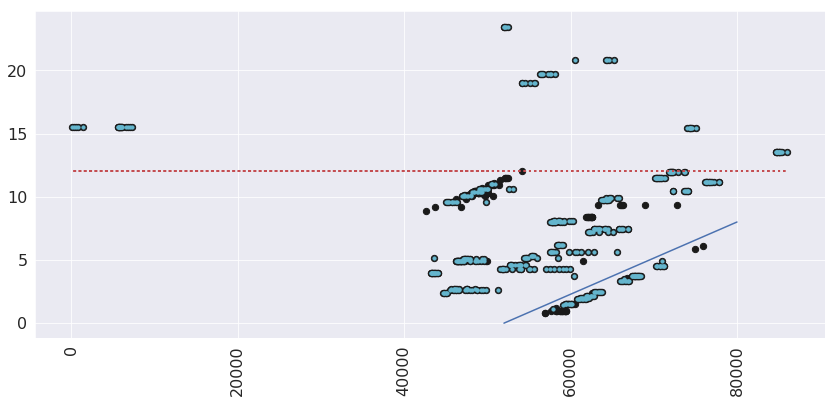

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

ax.scatter(WT.RecTime, WT.ZT, c='k', s=40)
ax.scatter(redWT.RecTime, redWT.ZT, c='c', s=10)

ax.plot(WT.RecTime, len(WT.DateStr)*[12.], ':r', lw=2)

ax.plot([52000, 80000], [0, 8], '-b')

plt.xticks(rotation='vertical')

fig.tight_layout()

In [13]:
WT['modRecTime']  = [x + 60*60*24 if x < 20000 else x for x in WT['RecTime']]
allDF['modRecTime'] = [x + 60*60*24 if x < 20000 else x for x in allDF['RecTime']]

In [14]:
def adjustZT(entry):
    if entry['ZT'] < 1./3500*(entry['RecTime'] - 52000):
#         print(entry.index, entry['ZT'], entry['RecTime'])
        return entry['ZT'] + 12
    else:
        return entry['ZT']

WT['modZT'] = WT.apply(adjustZT, axis=1)
WT['modZT_bins'] = pd.cut(x=WT['modZT'], bins=ZTBins,
    labels=[f"{ZTBins[ii]:d}-{ZTBins[ii+1]:d}" for ii in range(len(ZTBins)-1)])

In [15]:
redWT = WT[WT.RedCheck > 0]

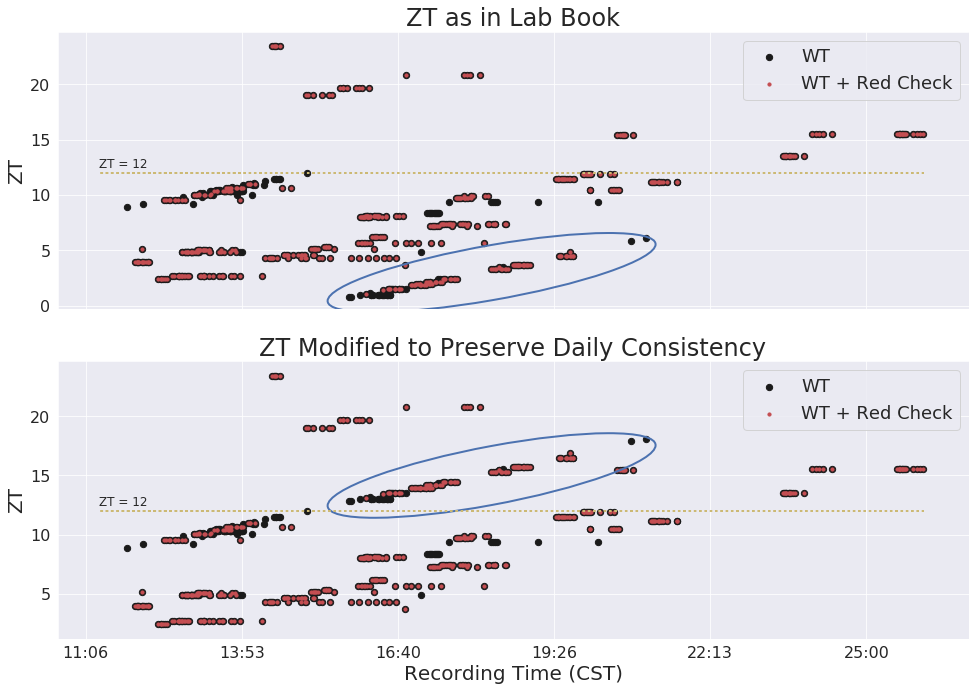

In [16]:
fig, ax = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

ax[0].scatter(WT.modRecTime, WT.ZT, c='k', s=40, label='WT')
ax[0].scatter(redWT.modRecTime, redWT.ZT, c='r', s=10, label='WT + Red Check')

ax[0].plot(WT.modRecTime, len(WT.DateStr)*[12.], ':y', lw=2)
ax[0].text(WT.modRecTime.min(), 12+.2, "ZT = 12", fontsize=12, ha='left', va='bottom')

ax[0].set_ylabel("ZT")
ax[0].set_title("ZT as in Lab Book")
ax[0].legend()

Ell1 = Ellipse(xy=[66000, 3], width=21000, height=5, angle=np.pi/180*0.8, facecolor='none')

ax[0].add_artist(Ell1)

Ell1.set_alpha(1)
Ell1.set_clip_box(ax[0].bbox)
Ell1.set_edgecolor('b')
Ell1.set_linewidth(2)

ax[1].scatter(WT.modRecTime, WT.modZT, c='k', s=40, label='WT')
ax[1].scatter(redWT.modRecTime, redWT.modZT, c='r', s=10, label='WT + Red Check')

ax[1].plot(WT.modRecTime, len(WT.DateStr)*[12.], ':y', lw=2)
ax[1].text(WT.modRecTime.min(), 12+.2, "ZT = 12", fontsize=12, ha='left', va='bottom')

ax[1].set_ylabel("ZT")
ax[1].set_title("ZT Modified to Preserve Daily Consistency")

ax[1].set_xlabel("Recording Time (CST)")

ax[1].legend()

Ell2 = Ellipse(xy=[66000, 15], width=21000, height=5, angle=np.pi/180*0.8, facecolor='none')

ax[1].add_artist(Ell2)

Ell2.set_alpha(1)
Ell2.set_clip_box(ax[1].bbox)
Ell2.set_edgecolor('b')
Ell2.set_linewidth(2)

fig.tight_layout()

xticks = [x for x in ax[1].get_xticklabels()]
xticks =[float(x.get_text()) for x in xticks]
ax[1].set_xticklabels([f"{int(x/3600):02d}:{int((x-3600*int(x/3600))/60):02d}" for x in xticks])

fig.tight_layout()

fig.savefig("./Figures/RedCheck_Overview/ZT_vs_RecTime_WT_RedCheck_Modification.pdf", format='pdf', dpi=600)

In [17]:
uniqueWT = WT.drop_duplicates(subset='modZT')
uniqueRedWT = redWT.drop_duplicates(subset='modZT')

# plt.scatter()

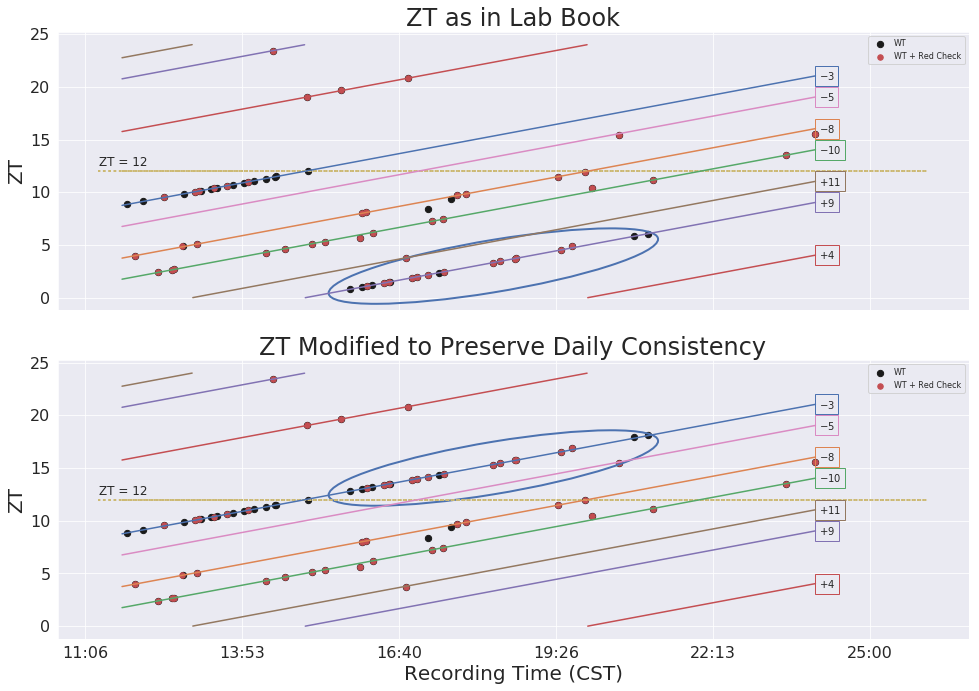

In [18]:
fig, ax = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

cmap = sns.color_palette()

ax[0].scatter(uniqueWT.modRecTime, uniqueWT.ZT, c='k', s=40, label='WT')
ax[0].scatter(uniqueRedWT.modRecTime, uniqueRedWT.ZT, c='r', s=30, label='WT + Red Check')

ax[0].plot(WT.modRecTime, len(WT.DateStr)*[12.], ':y', lw=2)
ax[0].text(WT.modRecTime.min(), 12+.2, "ZT = 12", fontsize=12, ha='left', va='bottom')

xgrid = np.linspace(uniqueWT.modRecTime.min(), uniqueWT.modRecTime.max(), 1000)
y1 = (1/3600*xgrid - 3)%24
y2 = (1/3600*xgrid - 8)%24
y3 = (1/3600*xgrid - 10)%24
y4 = (1/3600*xgrid + 4)%24
y5 = (1/3600*xgrid + 9)%24
y6 = (1/3600*xgrid + 11)%24
y7 = (1/3600*xgrid - 5)%24

y4jump = np.where(np.diff(y4)< 0)[0][0]+1
y5jump = np.where(np.diff(y5)< 0)[0][0]+1
y6jump = np.where(np.diff(y6)< 0)[0][0]+1

ax[0].plot(xgrid, y1, color=cmap[0])
ax[0].plot(xgrid, y2, color=cmap[1])
ax[0].plot(xgrid, y3, color=cmap[2])
ax[0].plot(xgrid[:y4jump], y4[:y4jump], color=cmap[3])
ax[0].plot(xgrid[y4jump:], y4[y4jump:], color=cmap[3])
ax[0].plot(xgrid[:y5jump], y5[:y5jump], color=cmap[4])
ax[0].plot(xgrid[y5jump:], y5[y5jump:], color=cmap[4])
ax[0].plot(xgrid[:y6jump], y6[:y6jump], color=cmap[5])
ax[0].plot(xgrid[y6jump:], y6[y6jump:], color=cmap[5])
ax[0].plot(xgrid, y7, color=cmap[6])

ax[0].text(uniqueWT.modRecTime.max()+200, y1[-1], r"$-3$", fontsize=10, ha='left', va='center',
           bbox={'facecolor':'none', 'edgecolor':cmap[0]})
ax[0].text(uniqueWT.modRecTime.max()+200, y2[-1], r"$-8$", fontsize=10, ha='left', va='center',
           bbox={'facecolor':'none', 'edgecolor':cmap[1]})
ax[0].text(uniqueWT.modRecTime.max()+200, y3[-1], r"$-10$", fontsize=10, ha='left', va='center',
           bbox={'facecolor':'none', 'edgecolor':cmap[2]})
ax[0].text(uniqueWT.modRecTime.max()+200, y4[-1], r"$+4$", fontsize=10, ha='left', va='center',
           bbox={'facecolor':'none', 'edgecolor':cmap[3]})
ax[0].text(uniqueWT.modRecTime.max()+200, y5[-1], r"$+9$", fontsize=10, ha='left', va='center',
           bbox={'facecolor':'none', 'edgecolor':cmap[4]})
ax[0].text(uniqueWT.modRecTime.max()+200, y6[-1], r"$+11$", fontsize=10, ha='left', va='center',
           bbox={'facecolor':'none', 'edgecolor':cmap[5]})
ax[0].text(uniqueWT.modRecTime.max()+200, y7[-1], r"$-5$", fontsize=10, ha='left', va='center',
           bbox={'facecolor':'none', 'edgecolor':cmap[6]})

ax[0].set_ylabel("ZT")
ax[0].set_title("ZT as in Lab Book")
ax[0].legend(fontsize=8)

Ell1 = Ellipse(xy=[66000, 3], width=21000, height=5, angle=np.pi/180*0.8, facecolor='none')

ax[0].add_artist(Ell1)

Ell1.set_alpha(1)
Ell1.set_clip_box(ax[0].bbox)
Ell1.set_edgecolor('b')
Ell1.set_linewidth(2)

ax[1].scatter(uniqueWT.modRecTime, uniqueWT.modZT, c='k', s=40, label='WT')
ax[1].scatter(uniqueRedWT.modRecTime, uniqueRedWT.modZT, c='r', s=30, label='WT + Red Check')

ax[1].plot(WT.modRecTime, len(WT.DateStr)*[12.], ':y', lw=2)
ax[1].text(WT.modRecTime.min(), 12+.2, "ZT = 12", fontsize=12, ha='left', va='bottom')


ax[1].plot(xgrid, y1, color=cmap[0])
ax[1].plot(xgrid, y2, color=cmap[1])
ax[1].plot(xgrid, y3, color=cmap[2])
ax[1].plot(xgrid[:y4jump], y4[:y4jump], color=cmap[3])
ax[1].plot(xgrid[y4jump:], y4[y4jump:], color=cmap[3])
ax[1].plot(xgrid[:y5jump], y5[:y5jump], color=cmap[4])
ax[1].plot(xgrid[y5jump:], y5[y5jump:], color=cmap[4])
ax[1].plot(xgrid[:y6jump], y6[:y6jump], color=cmap[5])
ax[1].plot(xgrid[y6jump:], y6[y6jump:], color=cmap[5])
ax[1].plot(xgrid, y7, color=cmap[6])

ax[1].text(uniqueWT.modRecTime.max()+200, y1[-1], r"$-3$", fontsize=10, ha='left', va='center',
           bbox={'facecolor':'none', 'edgecolor':cmap[0]})
ax[1].text(uniqueWT.modRecTime.max()+200, y2[-1], r"$-8$", fontsize=10, ha='left', va='center',
           bbox={'facecolor':'none', 'edgecolor':cmap[1]})
ax[1].text(uniqueWT.modRecTime.max()+200, y3[-1], r"$-10$", fontsize=10, ha='left', va='center',
           bbox={'facecolor':'none', 'edgecolor':cmap[2]})
ax[1].text(uniqueWT.modRecTime.max()+200, y4[-1], r"$+4$", fontsize=10, ha='left', va='center',
           bbox={'facecolor':'none', 'edgecolor':cmap[3]})
ax[1].text(uniqueWT.modRecTime.max()+200, y5[-1], r"$+9$", fontsize=10, ha='left', va='center',
           bbox={'facecolor':'none', 'edgecolor':cmap[4]})
ax[1].text(uniqueWT.modRecTime.max()+200, y6[-1], r"$+11$", fontsize=10, ha='left', va='center',
           bbox={'facecolor':'none', 'edgecolor':cmap[5]})
ax[1].text(uniqueWT.modRecTime.max()+200, y7[-1], r"$-5$", fontsize=10, ha='left', va='center',
           bbox={'facecolor':'none', 'edgecolor':cmap[6]})

ax[1].set_ylabel("ZT")
ax[1].set_title("ZT Modified to Preserve Daily Consistency")

ax[1].set_xlabel("Recording Time (CST)")

ax[1].legend(fontsize=8)

Ell2 = Ellipse(xy=[66000, 15], width=21000, height=5, angle=np.pi/180*0.8, facecolor='none')

ax[1].add_artist(Ell2)

Ell2.set_alpha(1)
Ell2.set_clip_box(ax[1].bbox)
Ell2.set_edgecolor('b')
Ell2.set_linewidth(2)

fig.tight_layout()

xticks = [x for x in ax[1].get_xticklabels()]
xticks =[float(x.get_text()) for x in xticks]
ax[1].set_xticklabels([f"{int(x/3600):02d}:{int((x-3600*int(x/3600))/60):02d}" for x in xticks])

fig.tight_layout()

fig.savefig("./Figures/RedCheck_Overview/ZT_vs_RecTime_WT_RedCheck_Modification_v2.pdf", format='pdf', dpi=600)

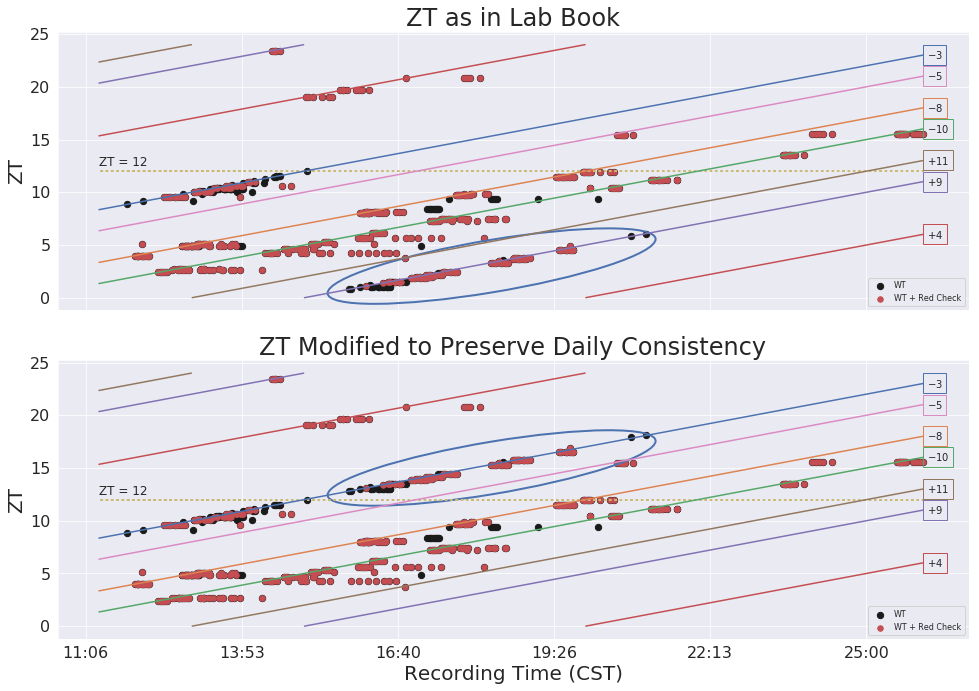

In [19]:
fig, ax = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

cmap = sns.color_palette()

ax[0].scatter(WT.modRecTime, WT.ZT, c='k', s=40, label='WT')
ax[0].scatter(redWT.modRecTime, redWT.ZT, c='r', s=30, label='WT + Red Check')

ax[0].plot(WT.modRecTime, len(WT.DateStr)*[12.], ':y', lw=2)
ax[0].text(WT.modRecTime.min(), 12+.2, "ZT = 12", fontsize=12, ha='left', va='bottom')

xgrid = np.linspace(WT.modRecTime.min(), WT.modRecTime.max(), 1000)
y1 = (1/3600*xgrid - 3)%24
y2 = (1/3600*xgrid - 8)%24
y3 = (1/3600*xgrid - 10)%24
y4 = (1/3600*xgrid + 4)%24
y5 = (1/3600*xgrid + 9)%24
y6 = (1/3600*xgrid + 11)%24
y7 = (1/3600*xgrid - 5)%24

y4jump = np.where(np.diff(y4)< 0)[0][0]+1
y5jump = np.where(np.diff(y5)< 0)[0][0]+1
y6jump = np.where(np.diff(y6)< 0)[0][0]+1

ax[0].plot(xgrid, y1, color=cmap[0])
ax[0].plot(xgrid, y2, color=cmap[1])
ax[0].plot(xgrid, y3, color=cmap[2])
ax[0].plot(xgrid[:y4jump], y4[:y4jump], color=cmap[3])
ax[0].plot(xgrid[y4jump:], y4[y4jump:], color=cmap[3])
ax[0].plot(xgrid[:y5jump], y5[:y5jump], color=cmap[4])
ax[0].plot(xgrid[y5jump:], y5[y5jump:], color=cmap[4])
ax[0].plot(xgrid[:y6jump], y6[:y6jump], color=cmap[5])
ax[0].plot(xgrid[y6jump:], y6[y6jump:], color=cmap[5])
ax[0].plot(xgrid, y7, color=cmap[6])

ax[0].text(WT.modRecTime.max()+200, y1[-1], r"$-3$", fontsize=10, ha='left', va='center',
           bbox={'facecolor':'none', 'edgecolor':cmap[0]})
ax[0].text(WT.modRecTime.max()+200, y2[-1], r"$-8$", fontsize=10, ha='left', va='center',
           bbox={'facecolor':'none', 'edgecolor':cmap[1]})
ax[0].text(WT.modRecTime.max()+200, y3[-1], r"$-10$", fontsize=10, ha='left', va='center',
           bbox={'facecolor':'none', 'edgecolor':cmap[2]})
ax[0].text(WT.modRecTime.max()+200, y4[-1], r"$+4$", fontsize=10, ha='left', va='center',
           bbox={'facecolor':'none', 'edgecolor':cmap[3]})
ax[0].text(WT.modRecTime.max()+200, y5[-1], r"$+9$", fontsize=10, ha='left', va='center',
           bbox={'facecolor':'none', 'edgecolor':cmap[4]})
ax[0].text(WT.modRecTime.max()+200, y6[-1], r"$+11$", fontsize=10, ha='left', va='center',
           bbox={'facecolor':'none', 'edgecolor':cmap[5]})
ax[0].text(WT.modRecTime.max()+200, y7[-1], r"$-5$", fontsize=10, ha='left', va='center',
           bbox={'facecolor':'none', 'edgecolor':cmap[6]})

ax[0].set_ylabel("ZT")
ax[0].set_title("ZT as in Lab Book")
ax[0].legend(fontsize=8)

Ell1 = Ellipse(xy=[66000, 3], width=21000, height=5, angle=np.pi/180*0.8, facecolor='none')

ax[0].add_artist(Ell1)

Ell1.set_alpha(1)
Ell1.set_clip_box(ax[0].bbox)
Ell1.set_edgecolor('b')
Ell1.set_linewidth(2)

ax[1].scatter(WT.modRecTime, WT.modZT, c='k', s=40, label='WT')
ax[1].scatter(redWT.modRecTime, redWT.modZT, c='r', s=30, label='WT + Red Check')

ax[1].plot(WT.modRecTime, len(WT.DateStr)*[12.], ':y', lw=2)
ax[1].text(WT.modRecTime.min(), 12+.2, "ZT = 12", fontsize=12, ha='left', va='bottom')


ax[1].plot(xgrid, y1, color=cmap[0])
ax[1].plot(xgrid, y2, color=cmap[1])
ax[1].plot(xgrid, y3, color=cmap[2])
ax[1].plot(xgrid[:y4jump], y4[:y4jump], color=cmap[3])
ax[1].plot(xgrid[y4jump:], y4[y4jump:], color=cmap[3])
ax[1].plot(xgrid[:y5jump], y5[:y5jump], color=cmap[4])
ax[1].plot(xgrid[y5jump:], y5[y5jump:], color=cmap[4])
ax[1].plot(xgrid[:y6jump], y6[:y6jump], color=cmap[5])
ax[1].plot(xgrid[y6jump:], y6[y6jump:], color=cmap[5])
ax[1].plot(xgrid, y7, color=cmap[6])

ax[1].text(WT.modRecTime.max()+200, y1[-1], r"$-3$", fontsize=10, ha='left', va='center',
           bbox={'facecolor':'none', 'edgecolor':cmap[0]})
ax[1].text(WT.modRecTime.max()+200, y2[-1], r"$-8$", fontsize=10, ha='left', va='center',
           bbox={'facecolor':'none', 'edgecolor':cmap[1]})
ax[1].text(WT.modRecTime.max()+200, y3[-1], r"$-10$", fontsize=10, ha='left', va='center',
           bbox={'facecolor':'none', 'edgecolor':cmap[2]})
ax[1].text(WT.modRecTime.max()+200, y4[-1], r"$+4$", fontsize=10, ha='left', va='center',
           bbox={'facecolor':'none', 'edgecolor':cmap[3]})
ax[1].text(WT.modRecTime.max()+200, y5[-1], r"$+9$", fontsize=10, ha='left', va='center',
           bbox={'facecolor':'none', 'edgecolor':cmap[4]})
ax[1].text(WT.modRecTime.max()+200, y6[-1], r"$+11$", fontsize=10, ha='left', va='center',
           bbox={'facecolor':'none', 'edgecolor':cmap[5]})
ax[1].text(WT.modRecTime.max()+200, y7[-1], r"$-5$", fontsize=10, ha='left', va='center',
           bbox={'facecolor':'none', 'edgecolor':cmap[6]})

ax[1].set_ylabel("ZT")
ax[1].set_title("ZT Modified to Preserve Daily Consistency")

ax[1].set_xlabel("Recording Time (CST)")

ax[1].legend(fontsize=8)

Ell2 = Ellipse(xy=[66000, 15], width=21000, height=5, angle=np.pi/180*0.8, facecolor='none')

ax[1].add_artist(Ell2)

Ell2.set_alpha(1)
Ell2.set_clip_box(ax[1].bbox)
Ell2.set_edgecolor('b')
Ell2.set_linewidth(2)

fig.tight_layout()

xticks = [x for x in ax[1].get_xticklabels()]
xticks =[float(x.get_text()) for x in xticks]
ax[1].set_xticklabels([f"{int(x/3600):02d}:{int((x-3600*int(x/3600))/60):02d}" for x in xticks])

fig.tight_layout()

fig.savefig("./Figures/RedCheck_Overview/ZT_vs_RecTime_WT_RedCheck_Modification_v3.pdf", format='pdf', dpi=600)

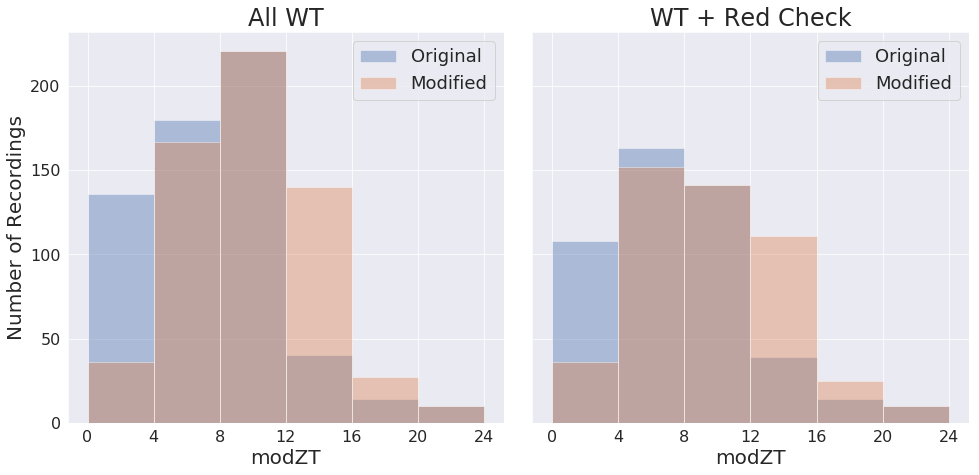

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(14, 7), sharex=True, sharey=True)

bins = np.arange(0, 24.1, 4)

sns.distplot(WT.ZT.dropna(), bins=bins, kde=False, ax=ax[0], label='Original')
sns.distplot(WT.modZT.dropna(), bins=bins, kde=False, ax=ax[0], label='Modified')

ax[0].set_ylabel("Number of Recordings")
ax[0].legend()
ax[0].set_title("All WT")
ax[0].set_xticks(bins)

sns.distplot(redWT.ZT.dropna(), bins=bins, kde=False, ax=ax[1], label='Original')
sns.distplot(redWT.modZT.dropna(), bins=bins, kde=False, ax=ax[1], label='Modified')

ax[1].legend()
ax[1].set_title("WT + Red Check")

fig.tight_layout()

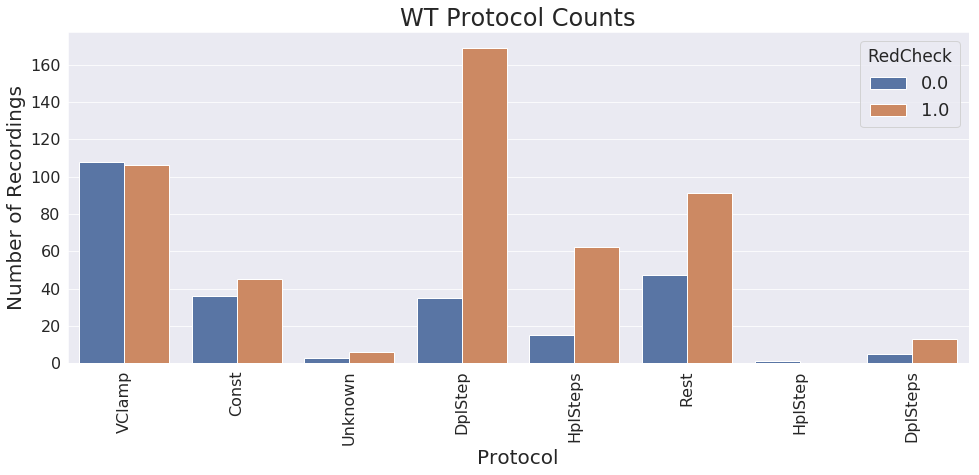

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(14, 7), sharey=True)

sns.countplot(data=WT, x="Prot", ax=ax, hue="RedCheck")

for tick in ax.get_xticklabels():
    tick.set_rotation(90)
ax.set_xlabel("Protocol")
ax.set_ylabel("Number of Recordings")

ax.set_title("WT Protocol Counts")

fig.tight_layout()

In [104]:
restRedWT = redWT.loc[redWT.Prot == 'Rest']
restRedWT.describe()
restRedWT.FR = restRedWT.FR.apply(float)
restRedWT.PSD = restRedWT.PSD.apply(float)
restRedWT = restRedWT.loc[restRedWT.PSD < -20]
restRedWT = restRedWT.loc[restRedWT.NEps <= 1]
restRedWT = restRedWT.loc[restRedWT.PSD > -55]

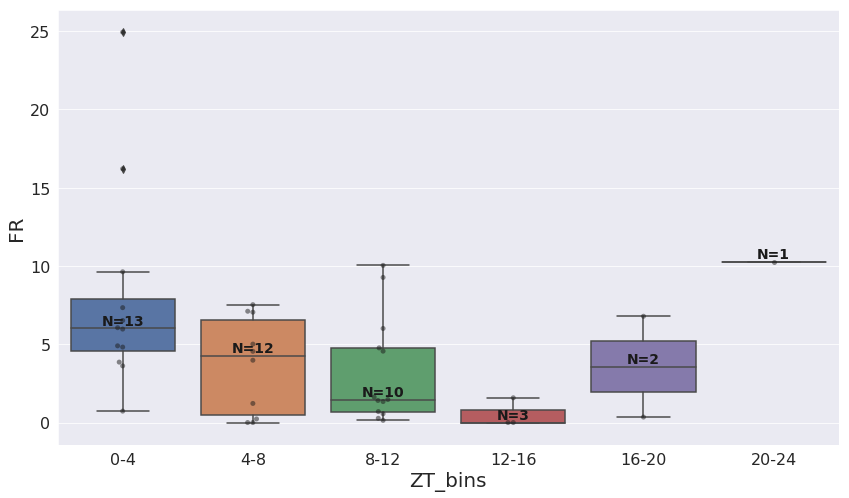

In [105]:
fig, ax = plt.subplots(1, 1, figsize=(14, 8))

sns.boxplot(data=restRedWT, x="ZT_bins", y="FR")
sns.swarmplot(x='ZT_bins', y='FR', ax=ax, data=restRedWT, color='k',
    alpha=0.5)

# Calculate number of obs per group & median to position labels
medians = restRedWT.groupby(['ZT_bins'])['FR'].median().values
nobs = restRedWT['ZT_bins'].value_counts().values
nobs = [str(x) for x in nobs.tolist()]
nobs = ["N=" + i for i in nobs]
 
# Add it to the plot
pos = range(len(nobs))
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick], medians[tick] + 0.03, nobs[tick], va='bottom',
        ha='center', size='x-small', color='k', weight='semibold')

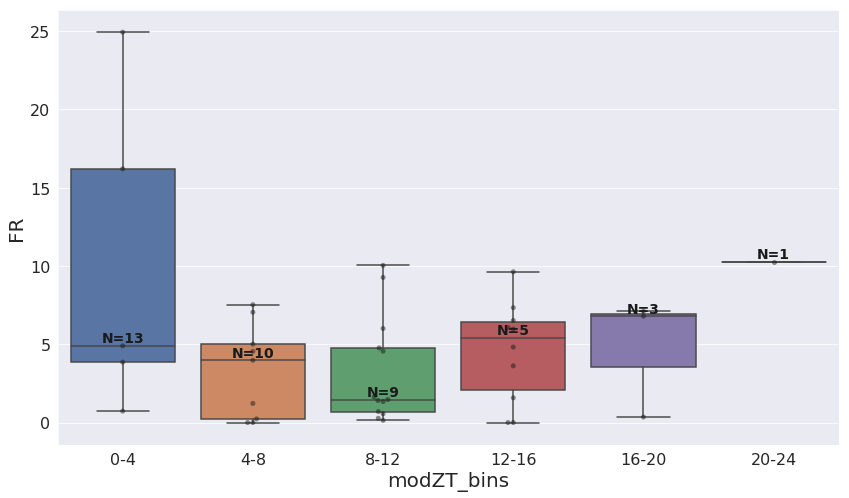

In [106]:
fig, ax = plt.subplots(1, 1, figsize=(14, 8))

sns.boxplot(data=restRedWT, x="modZT_bins", y="FR")
sns.swarmplot(x='modZT_bins', y='FR', ax=ax, data=restRedWT, color='k',
    alpha=0.5)

# Calculate number of obs per group & median to position labels
medians = restRedWT.groupby(['modZT_bins'])['FR'].median().values
nobs = restRedWT['modZT_bins'].value_counts().values
nobs = [str(x) for x in nobs.tolist()]
nobs = ["N=" + i for i in nobs]
 
# Add it to the plot
pos = range(len(nobs))
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick], medians[tick] + 0.03, nobs[tick], va='bottom',
        ha='center', size='x-small', color='k', weight='semibold')

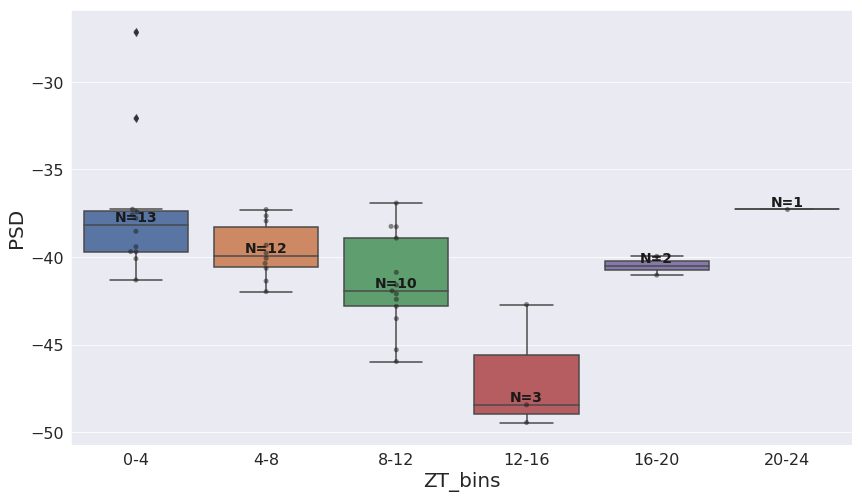

In [107]:
fig, ax = plt.subplots(1, 1, figsize=(14, 8))

sns.boxplot(data=restRedWT, x="ZT_bins", y="PSD")
sns.swarmplot(x='ZT_bins', y='PSD', ax=ax, data=restRedWT, color='k',
    alpha=0.5)

# Calculate number of obs per group & median to position labels
medians = restRedWT.groupby(['ZT_bins'])['PSD'].median().values
nobs = restRedWT['ZT_bins'].value_counts().values
nobs = [str(x) for x in nobs.tolist()]
nobs = ["N=" + i for i in nobs]
 
# Add it to the plot
pos = range(len(nobs))
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick], medians[tick] + 0.03, nobs[tick], va='bottom',
        ha='center', size='x-small', color='k', weight='semibold')

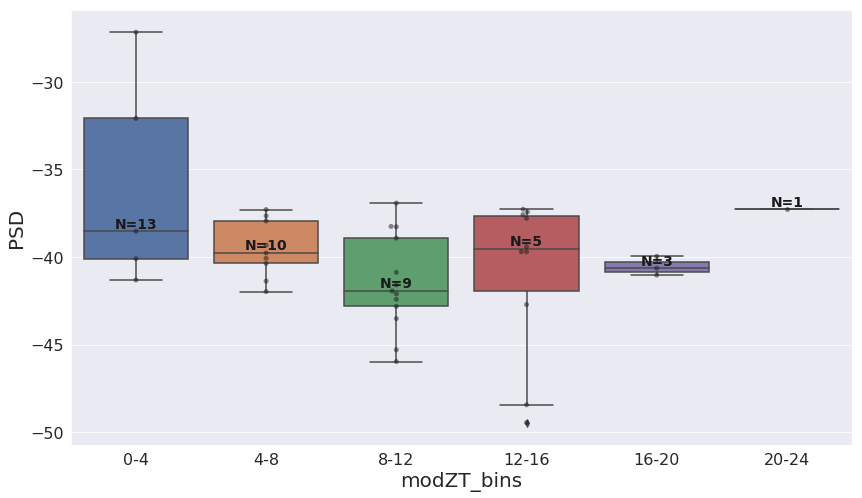

In [108]:
fig, ax = plt.subplots(1, 1, figsize=(14, 8))

sns.boxplot(data=restRedWT, x="modZT_bins", y="PSD")
sns.swarmplot(x='modZT_bins', y='PSD', ax=ax, data=restRedWT, color='k',
    alpha=0.5)

# Calculate number of obs per group & median to position labels
medians = restRedWT.groupby(['modZT_bins'])['PSD'].median().values
nobs = restRedWT['modZT_bins'].value_counts().values
nobs = [str(x) for x in nobs.tolist()]
nobs = ["N=" + i for i in nobs]
 
# Add it to the plot
pos = range(len(nobs))
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick], medians[tick] + 0.03, nobs[tick], va='bottom',
        ha='center', size='x-small', color='k', weight='semibold')

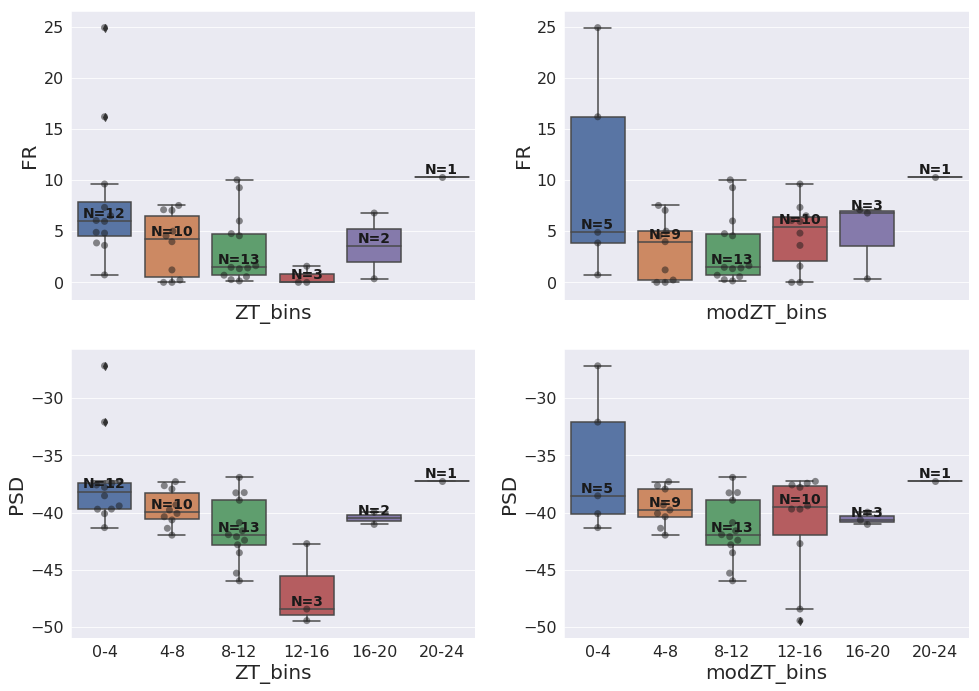

In [118]:
fig, ax = plt.subplots(2, 2, figsize=(14, 10), sharex=True)

###### PANEL 0, 0
sns.boxplot(data=restRedWT, x="ZT_bins", y="FR", ax=ax[0, 0])
sns.swarmplot(x='ZT_bins', y='FR', ax=ax[0, 0], data=restRedWT, color='k',
    alpha=0.5, s=7)

# Calculate number of obs per group & median to position labels
medians = restRedWT.groupby(['ZT_bins'])['FR'].median().values
nobs = restRedWT['ZT_bins'].value_counts().sort_index().values
nobs = [str(x) for x in nobs.tolist()]
nobs = ["N=" + i for i in nobs]
 
# Add it to the plot
pos = range(len(nobs))
for tick,label in zip(pos, ax[1, 0].get_xticklabels()):
    ax[0, 0].text(pos[tick], medians[tick] + 0.03, nobs[tick], va='bottom',
        ha='center', size='x-small', color='k', weight='semibold')

###### PANEL 1, 0
sns.boxplot(data=restRedWT, x="modZT_bins", y="FR", ax=ax[0, 1])
sns.swarmplot(x='modZT_bins', y='FR', ax=ax[0, 1], data=restRedWT, color='k',
    alpha=0.5, s=7)

# Calculate number of obs per group & median to position labels
medians = restRedWT.groupby(['modZT_bins'])['FR'].median().values
nobs = restRedWT['modZT_bins'].value_counts().sort_index().values
nobs = [str(x) for x in nobs.tolist()]
nobs = ["N=" + i for i in nobs]
 
# Add it to the plot
pos = range(len(nobs))
for tick, label in zip(pos, ax[1, 1].get_xticklabels()):
    ax[0, 1].text(pos[tick], medians[tick] + 0.03, nobs[tick], va='bottom',
        ha='center', size='x-small', color='k', weight='semibold')

###### PANEL 0, 1  
sns.boxplot(data=restRedWT, x="ZT_bins", y="PSD", ax=ax[1, 0])
sns.swarmplot(x='ZT_bins', y='PSD', ax=ax[1, 0], data=restRedWT, color='k',
    alpha=0.5, s=7)

# Calculate number of obs per group & median to position labels
medians = restRedWT.groupby(['ZT_bins'])['PSD'].median().values
nobs = restRedWT['ZT_bins'].value_counts().sort_index().values
nobs = [str(x) for x in nobs.tolist()]
nobs = ["N=" + i for i in nobs]
 
# Add it to the plot
pos = range(len(nobs))
for tick,label in zip(pos, ax[1, 0].get_xticklabels()):
    ax[1, 0].text(pos[tick], medians[tick] + 0.03, nobs[tick], va='bottom',
        ha='center', size='x-small', color='k', weight='semibold')
    
###### PANEL 1, 1   
sns.boxplot(data=restRedWT, x="modZT_bins", y="PSD", ax=ax[1, 1])
sns.swarmplot(x='modZT_bins', y='PSD', ax=ax[1, 1], data=restRedWT, color='k',
    alpha=0.5, s=7)

# Calculate number of obs per group & median to position labels
medians = restRedWT.groupby(['modZT_bins'])['PSD'].median().values
nobs = restRedWT['modZT_bins'].value_counts().sort_index().values
nobs = [str(x) for x in nobs.tolist()]
nobs = ["N=" + i for i in nobs]
 
# Add it to the plot
pos = range(len(nobs))
for tick, label in zip(pos, ax[1, 1].get_xticklabels()):
    ax[1, 1].text(pos[tick], medians[tick] + 0.03, nobs[tick], va='bottom',
        ha='center', size='x-small', color='k', weight='semibold')
    
fig.tight_layout()

fig.savefig("./Figures/RedCheck_Overview/FR_PSD_vs_ZT_modZT_RestProt_RedCheck.pdf",
           format='pdf', dpi=600)

In [110]:
# restRedWT[restRedWT.modZT_bins == '0-4']
# restRedWT.modZT_bins.value_counts().sort_index()
restRedWT[restRedWT.FR > 15].loc[:, :"C"]

,DateStr,DateNo,RecTime,ZT,RecNo,NrnNo,Geno,Prot,IApp,NEps,FR,Amp,PSD,RI,tau,C
Date,,,,,,,,,,,,,,,,
Fri Apr 1 00:00:00 2011,4012011,21,45530.432,2.650000,0.0,NaN,WT,Rest,0,1,16.21,-16.0,-32.09,NaN,NaN,NaN
Fri Apr 22 00:00:00 2011,4222011,28,45642.828,2.683333,0.0,0.0,WT,Rest,0,1,24.94,-15.3,-27.17,NaN,NaN,NaN


In [117]:

restRedWT[restRedWT.modZT_bins == '4-8'].loc[:, :"C"]

,DateStr,DateNo,RecTime,ZT,RecNo,NrnNo,Geno,Prot,IApp,NEps,FR,Amp,PSD,RI,tau,C
Date,,,,,,,,,,,,,,,,
Wed Apr 6 00:00:00 2011,4062011,22,51517.201,4.283333,0.0,NaN,WT,Rest,0,1,7.05,1.96,-37.65,NaN,NaN,NaN
Fri Apr 8 00:00:00 2011,4082011,23,57475.529,5.633333,0.0,0.0,WT,Rest,0,1,3.98,-4.05,-40.07,NaN,NaN,NaN
Fri Apr 22 00:00:00 2011,4222011,28,58330.218,6.183333,13.0,1.0,WT,Rest,0,1,1.22,-1.38,-41.37,NaN,NaN,NaN
Wed Dec 7 00:00:00 2011,12072011,49,57613.332,8.000000,0.0,0.0,WT,Rest,0,1,0.00,NaN,-41.97,NaN,NaN,NaN
Wed Dec 21 00:00:00 2011,12212011,55,47107.467,5.083333,0.0,0.0,WT,Rest,0,1,5.01,-9.59,-39.77,NaN,NaN,NaN
Wed Dec 21 00:00:00 2011,12212011,55,47194.311,5.083333,1.0,0.0,WT,Rest,0,1,4.55,-9.13,-40.36,NaN,NaN,NaN
Fri Jan 6 00:00:00 2012,1062012,58,46384.574,4.883333,1.0,0.0,WT,Rest,0,1,7.53,-17.07,-37.29,NaN,NaN,NaN
Fri Jan 6 00:00:00 2012,1062012,58,47919.996,4.883333,13.0,0.0,WT,Rest,0,1,0.00,NaN,-37.94,NaN,NaN,NaN
Fri Jan 6 00:00:00 2012,1062012,58,48567.981,4.883333,15.0,0.0,WT,Rest,0,1,0.23,-6.11,-39.32,NaN,NaN,NaN


In [46]:
restRedWT[['RecNo','FR', 'PSD', 'Amp']].describe()

,RecNo,FR,PSD,Amp
count,50.000000,50.000000,50.00000,40.000000
mean,7.900000,4.549000,-40.19700,-10.486750
std,9.315885,5.390603,6.05151,7.960357
min,0.000000,0.000000,-63.96000,-23.780000
25%,0.000000,0.290000,-42.33250,-16.600000
50%,4.000000,3.740000,-40.08000,-11.970000
75%,13.000000,6.722500,-37.82750,-5.830000
max,35.000000,24.940000,-21.34000,6.960000


2012_11_05_0023.abf
Recorded at 18:46:12:302
File has 3 channels
There are 62000 data points per channel
The channels are:
	Vm_scaled	(mV)
	I_output	(pA)
	Temp	(deg)
There are 1 episodes


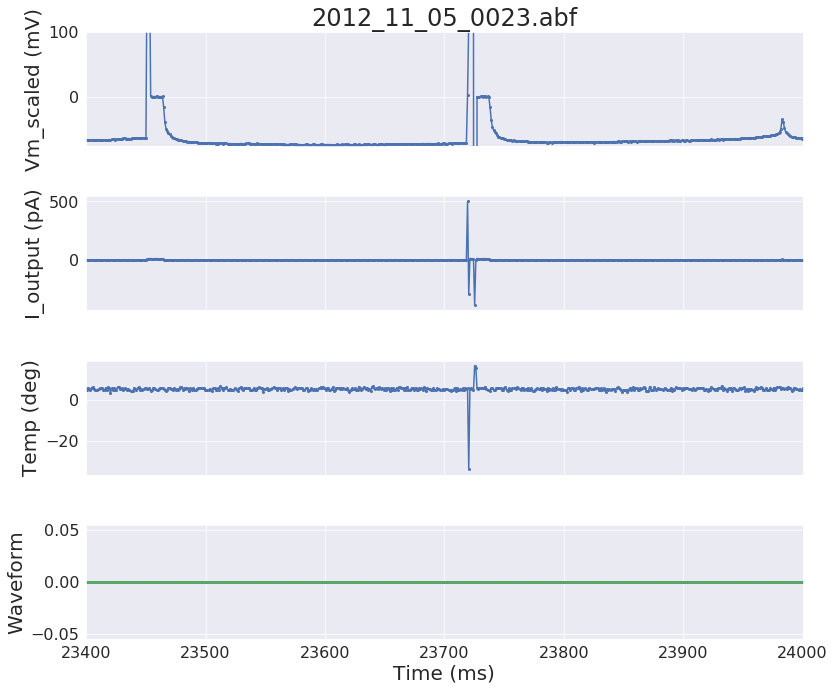

In [103]:
year = '2012'
month = 'nov 2012'
day = '11052012'

fileDir = os.path.join(dataDir, year, month, day)
fileList = sorted(os.listdir(fileDir))
for file in fileList:
    if 'abf' not in file:
        continue

    if "23.abf" not in file:
        continue

    print(file)

    [d, h] = abf.ABF_read(file, datadir=fileDir)

    hour = int(h['lFileStartTime']/3600)
    mins = int((h['lFileStartTime'] - hour*3600)/60)
    secs = int(h['lFileStartTime'] % 60)
    msec = int((h['lFileStartTime'] - int(h['lFileStartTime']))*1000)

    print(f"Recorded at {hour:02d}:{mins:02d}:{secs:02d}:{msec:03d}")
    print(f"File has {h['nADCNumChannels']} channels")
    print(f"There are {h['dataPtsPerChan']} data points per channel")
    print(f"The channels are:")
    for name, unit in zip(h['recChNames'], h['recChUnits']):
        print(f"\t{name}\t({unit})")
    print(f"There are {h['lActualEpisodes']} episodes")

    timebase = abf.GetTimebase(h, 0)

    fig, axes = plt.subplots(h['nADCNumChannels']+1, 1, 
        figsize=(12,10), sharex=True)

    for chan in range(h['nADCNumChannels']):
        ax = axes[chan]

        name = h['recChNames'][chan]
        unit = h['recChUnits'][chan]

        ax.plot(timebase, d[:, chan], '-o', ms=2)
        ax.set_ylabel(f"{name} ({unit})")

    ax = axes[-1]
    for chan in range(h['lActualEpisodes']):
        waveform = abf.GetWaveform(h, chan+1)
        ax.plot(timebase, waveform, '-o', ms=2)

    ax.set_xlabel("Time (ms)")
    ax.set_ylabel("Waveform")
          
    axes[0].set_ylim(-75, 100)
    axes[0].set_xlim(23400, 24000)

    axes[0].set_title(file)

    fig.tight_layout()

In [97]:
restRedWT[restRedWT.PSD< -50].loc[:, :'C']

,DateStr,DateNo,RecTime,ZT,RecNo,NrnNo,Geno,Prot,IApp,NEps,FR,Amp,PSD,RI,tau,C
Date,,,,,,,,,,,,,,,,
Mon Nov 5 00:00:00 2012,11052012,132,67572.303,3.716667,23.0,5.0,WT,Rest,0,1,0.0,NaN,-63.96,NaN,NaN,NaN


In [93]:
d.shape

(62000, 3, 1)